In [1]:
from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + ".,;'-"
n_letters = len(all_letters)

n_letters

57

In [2]:
def findFiles(path):
    return glob.glob(path)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )
    
def readLines(filename):
    with open(filename, encoding='utf-8') as some_file:
        return [unicodeToAscii(line.strip()) for line in some_file]

In [3]:
category_lines = {}
all_categories = []
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

print('# categories:', n_categories, all_categories)

# categories: 19 ['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Indian', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']


In [4]:
print(unicodeToAscii("O'Néàl"))

O'Neal


In [5]:
import torch 
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [6]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) 
    return torch.LongTensor(letter_indexes)

def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

In [7]:
criterion = nn.NLLLoss()
rnn = RNN(n_letters, 128, n_letters)

learning_rate = 0.0005

In [8]:
rnn

RNN(
  (i2h): Linear(in_features=204, out_features=128, bias=True)
  (i2o): Linear(in_features=204, out_features=57, bias=True)
  (o2o): Linear(in_features=185, out_features=57, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (softmax): LogSoftmax(dim=1)
)

In [9]:
def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = torch.Tensor([0]) # you can also just simply use ``loss = 0``

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

In [10]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 

start = time.time()

In [11]:
for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 53s (5000 5%) 3.2352
1m 23s (10000 10%) 2.8727
1m 48s (15000 15%) 2.6197
2m 12s (20000 20%) 2.4504
2m 37s (25000 25%) 2.8964
3m 1s (30000 30%) 2.1813
3m 25s (35000 35%) 2.1913
3m 49s (40000 40%) 2.3955
4m 13s (45000 45%) 2.2521
4m 38s (50000 50%) 2.8953
5m 1s (55000 55%) 2.0535
5m 24s (60000 60%) 1.4887
5m 46s (65000 65%) 2.1959
6m 8s (70000 70%) 2.8418
6m 29s (75000 75%) 3.3795
6m 55s (80000 80%) 1.9919
7m 19s (85000 85%) 2.1953
7m 44s (90000 90%) 2.3456
8m 8s (95000 95%) 2.7718
8m 32s (100000 100%) 2.7492


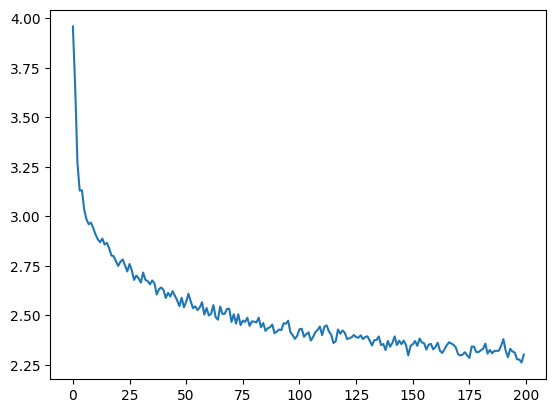

In [12]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)

In [13]:
max_length = 20

def sample(category, start_letter='S'):
    with torch.no_grad():  
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

def samples(category, start_letters='STUV'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

In [14]:
samples('Indian', 'IND')

Iara
Naran
Deran


In [15]:
samples('Russian', 'RUS')

Rakinov
Uovellov
Sharovev


In [16]:
samples('Japanese', 'JPN')

Jamara
Pamara
Naki
